<a href="https://colab.research.google.com/github/bksgupta/course-v3/blob/master/lesson7_superres.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Super resolution

In [1]:
import fastai
from fastai.vision import *
from fastai.callbacks import *
from fastai.utils.mem import *

from torchvision.models import vgg16_bn

In [2]:
!pip install 'torch==1.4' 'torchvision==0.5.0'

     |████████████████████████████████| 753.4MB 21kB/s 
     |████████████████████████████████| 4.0MB 46.9MB/s 
  Found existing installation: torch 1.5.1+cu101
    Uninstalling torch-1.5.1+cu101:
      Successfully uninstalled torch-1.5.1+cu101
  Found existing installation: torchvision 0.6.1+cu101
    Uninstalling torchvision-0.6.1+cu101:
      Successfully uninstalled torchvision-0.6.1+cu101


In [2]:
path = untar_data(URLs.PETS)
path_hr = path/'images'
path_lr = path/'small-96'
path_mr = path/'small-256'

In [3]:
path

PosixPath('/root/.fastai/data/oxford-iiit-pet')

In [4]:
(path).ls()

[PosixPath('/root/.fastai/data/oxford-iiit-pet/annotations'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images')]

In [5]:
il = ImageList.from_folder(path_hr)

In [6]:
il.items[0].name

'saint_bernard_97.jpg'

In [43]:
il.items[0]

PosixPath('/root/.fastai/data/oxford-iiit-pet/images/saint_bernard_97.jpg')

In [46]:
open_image(il.items[0]).shape

torch.Size([3, 333, 500])

In [37]:
from pathlib import Path

Path(r'/root/.fastai/data/oxford-iiit-pet/images/saint_bernard_97.jpg').relative_to(path_hr)

PosixPath('saint_bernard_97.jpg')

In [8]:
def resize_one(fn, i, path, size):
    # print(fn,i)
    # import sys
    
    dest = path/fn.relative_to(path_hr)
    # print(dest)
    # sys.exit(12) 
    dest.parent.mkdir(parents=True, exist_ok=True)
    img = PIL.Image.open(fn)
    targ_sz = resize_to(img, size, use_min=True)
    img = img.resize(targ_sz, resample=PIL.Image.BILINEAR).convert('RGB')
    img.save(dest, quality=60)

In [10]:
il.items

array([PosixPath('/root/.fastai/data/oxford-iiit-pet/images/saint_bernard_97.jpg'),
       PosixPath('/root/.fastai/data/oxford-iiit-pet/images/Persian_260.jpg'),
       PosixPath('/root/.fastai/data/oxford-iiit-pet/images/pug_69.jpg'),
       PosixPath('/root/.fastai/data/oxford-iiit-pet/images/english_setter_17.jpg'), ...,
       PosixPath('/root/.fastai/data/oxford-iiit-pet/images/miniature_pinscher_7.jpg'),
       PosixPath('/root/.fastai/data/oxford-iiit-pet/images/havanese_87.jpg'),
       PosixPath('/root/.fastai/data/oxford-iiit-pet/images/saint_bernard_89.jpg'),
       PosixPath('/root/.fastai/data/oxford-iiit-pet/images/keeshond_125.jpg')], dtype=object)

In [9]:
# create smaller image sets the first time this nb is run
sets = [(path_lr, 96), (path_mr, 256)]
for p,size in sets:
    if not p.exists(): 
        print(f"resizing to {size} into {p}")
        parallel(partial(resize_one, path=p, size=size), il.items)

resizing to 96 into /root/.fastai/data/oxford-iiit-pet/small-96


resizing to 256 into /root/.fastai/data/oxford-iiit-pet/small-256


In [14]:
(path_hr/'havanese_87.jpg').name

'havanese_87.jpg'

In [15]:
bs,size=32,128
arch = models.resnet34

src = ImageImageList.from_folder(path_lr).split_by_rand_pct(0.1, seed=42)

In [16]:
def get_data(bs,size):
    data = (src.label_from_func(lambda x: path_hr/x.name)
           .transform(get_transforms(max_zoom=2.), size=size, tfm_y=True)
           .databunch(bs=bs).normalize(imagenet_stats, do_y=True))

    data.c = 3
    return data

In [17]:
data = get_data(bs,size)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/u

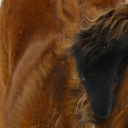

In [18]:
data.train_ds[0][1]

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/u

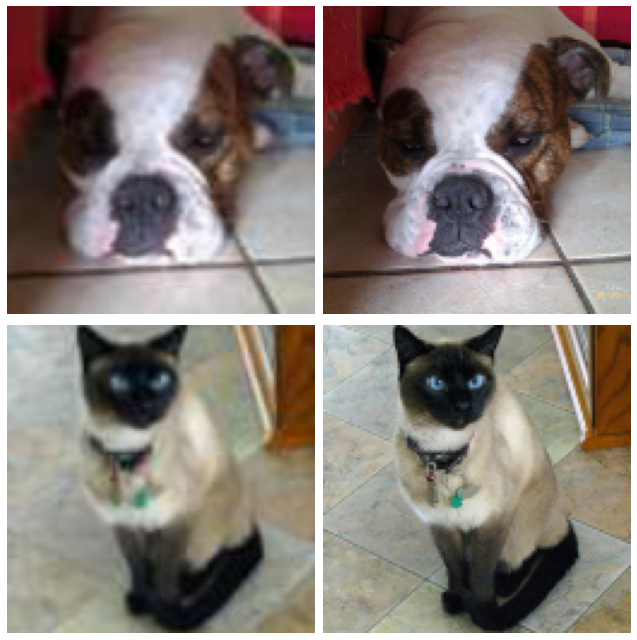

In [19]:
data.show_batch(ds_type=DatasetType.Valid, rows=2, figsize=(9,9))

## Feature loss

In [25]:
t = data.valid_ds[0][1].data
print (t.shape)
t = torch.stack([t,t])

torch.Size([3, 128, 128])


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "


In [26]:
t.shape

torch.Size([2, 3, 128, 128])

In [ ]:
# t = torch.stack([t,t])

In [ ]:
# t.shape

torch.Size([2, 3, 128, 128])

In [ ]:
# t.transpose(1,2).shape

torch.Size([2, 128, 3, 128])

In [22]:
# n,c,h,w = t.size()
# t = t.view(n, c, -1)
# # a = t@t.transpose(1,2)
# # a.shape
# t.shape

torch.Size([2, 3, 16384])

In [ ]:
# t.transpose(1,2).shape

torch.Size([2, 16384, 3])

In [ ]:
# a = t@t.transpose(1,2)
# a.shape

torch.Size([2, 3, 3])

In [27]:
def gram_matrix(x):
    n,c,h,w = x.size()
    x = x.view(n, c, -1)
    return (x @ x.transpose(1,2))/(c*h*w)

In [28]:
gram_matrix(t)

tensor([[[0.0964, 0.0874, 0.0889],
         [0.0874, 0.0827, 0.0843],
         [0.0889, 0.0843, 0.0865]],

        [[0.0964, 0.0874, 0.0889],
         [0.0874, 0.0827, 0.0843],
         [0.0889, 0.0843, 0.0865]]])

In [29]:
base_loss = F.l1_loss

In [30]:
vgg_m = vgg16_bn(True).features.cuda().eval()
requires_grad(vgg_m, False)

Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/checkpoints/vgg16_bn-6c64b313.pth


In [31]:
blocks = [i-1 for i,o in enumerate(children(vgg_m)) if isinstance(o,nn.MaxPool2d)]
blocks, [vgg_m[i] for i in blocks]

([5, 12, 22, 32, 42],
 [ReLU(inplace=True),
  ReLU(inplace=True),
  ReLU(inplace=True),
  ReLU(inplace=True),
  ReLU(inplace=True)])

In [32]:
hook_outputs??

In [33]:
class FeatureLoss(nn.Module):
    def __init__(self, m_feat, layer_ids, layer_wgts):
        super().__init__()
        self.m_feat = m_feat
        self.loss_features = [self.m_feat[i] for i in layer_ids]
        self.hooks = hook_outputs(self.loss_features, detach=False)
        self.wgts = layer_wgts
        self.metric_names = ['pixel',] + [f'feat_{i}' for i in range(len(layer_ids))
              ] + [f'gram_{i}' for i in range(len(layer_ids))]

    def make_features(self, x, clone=False):
        self.m_feat(x)
        return [(o.clone() if clone else o) for o in self.hooks.stored]
    
    def forward(self, input, target):
        out_feat = self.make_features(target, clone=True)
        in_feat = self.make_features(input)
        self.feat_losses = [base_loss(input,target)]
        self.feat_losses += [base_loss(f_in, f_out)*w
                             for f_in, f_out, w in zip(in_feat, out_feat, self.wgts)]
        self.feat_losses += [base_loss(gram_matrix(f_in), gram_matrix(f_out))*w**2 * 5e3
                             for f_in, f_out, w in zip(in_feat, out_feat, self.wgts)]
        self.metrics = dict(zip(self.metric_names, self.feat_losses))
        return sum(self.feat_losses)
    
    def __del__(self): self.hooks.remove()

In [34]:
feat_loss = FeatureLoss(vgg_m, blocks[2:5], [5,15,2])

## Train

In [38]:
wd = 1e-3
learn = unet_learner(data, arch, wd=wd, loss_func=feat_loss, callback_fns=LossMetrics,
                     blur=True, norm_type=NormType.Weight)
gc.collect();

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/u

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


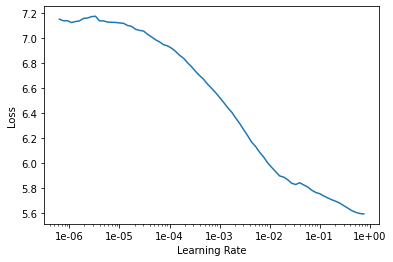

In [39]:
learn.lr_find()
learn.recorder.plot()

In [40]:
lr = 1e-3

In [41]:
def do_fit(save_name, lrs=slice(lr), pct_start=0.9):
    learn.fit_one_cycle(10, lrs, pct_start=pct_start)
    learn.save(save_name)
    learn.show_results(rows=1, imgsize=5)

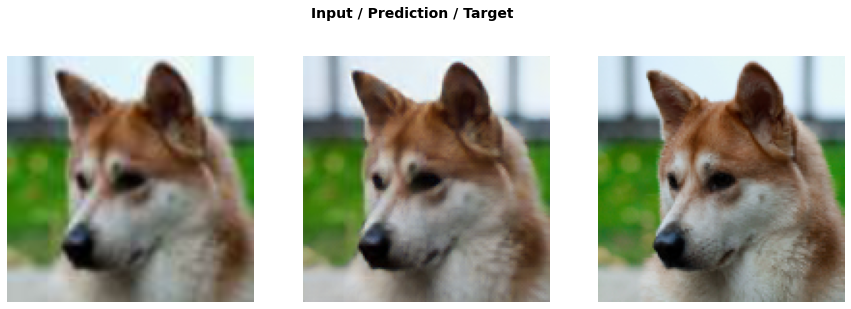

In [ ]:
do_fit('1a', slice(lr*10))

In [ ]:
learn.unfreeze()

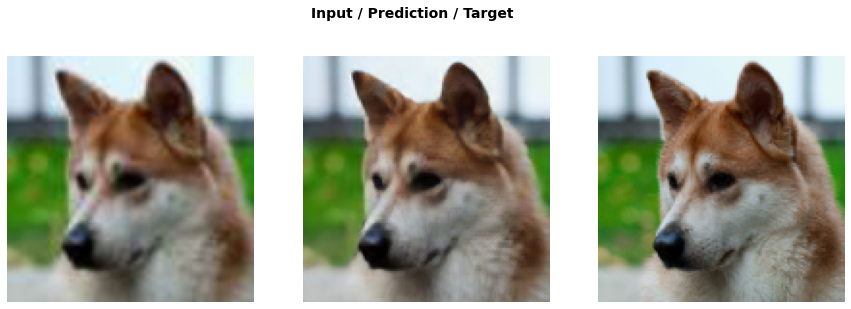

In [ ]:
do_fit('1b', slice(1e-5,lr))

In [ ]:
data = get_data(12,size*2)

In [ ]:
learn.data = data
learn.freeze()
gc.collect()

21208

In [ ]:
learn.load('1b');

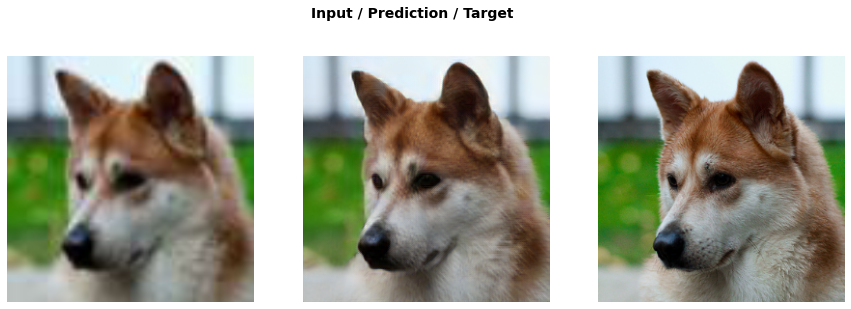

In [ ]:
do_fit('2a')

In [ ]:
learn.unfreeze()

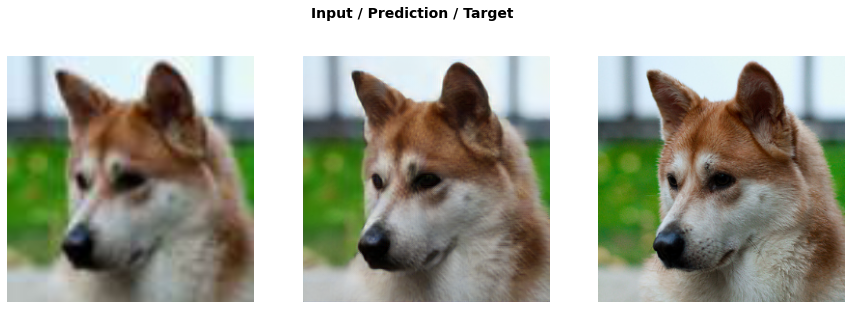

In [ ]:
do_fit('2b', slice(1e-6,1e-4), pct_start=0.3)

## Test

In [ ]:
learn = None
gc.collect();

In [ ]:
256/320*1024

819.2

In [ ]:
256/320*1600

1280.0

In [ ]:
free = gpu_mem_get_free_no_cache()
# the max size of the test image depends on the available GPU RAM 
if free > 8000: size=(1280, 1600) # >  8GB RAM
else:           size=( 820, 1024) # <= 8GB RAM
print(f"using size={size}, have {free}MB of GPU RAM free")

using size=(1280, 1600), have 14965MB of GPU RAM free


In [ ]:
learn = unet_learner(data, arch, loss_func=F.l1_loss, blur=True, norm_type=NormType.Weight)

In [ ]:
data_mr = (ImageImageList.from_folder(path_mr).split_by_rand_pct(0.1, seed=42)
          .label_from_func(lambda x: path_hr/x.name)
          .transform(get_transforms(), size=size, tfm_y=True)
          .databunch(bs=1).normalize(imagenet_stats, do_y=True))
data_mr.c = 3

In [ ]:
learn.load('2b');

In [ ]:
learn.data = data_mr

In [ ]:
fn = data_mr.valid_ds.x.items[0]; fn

PosixPath('/root/.fastai/data/oxford-iiit-pet/small-256/shiba_inu_108.jpg')

In [ ]:
img = open_image(fn); img.shape

torch.Size([3, 384, 256])

In [ ]:
p,img_hr,b = learn.predict(img)

In [ ]:
unet_learner.predict??

Object `unet_learner.predict` not found.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


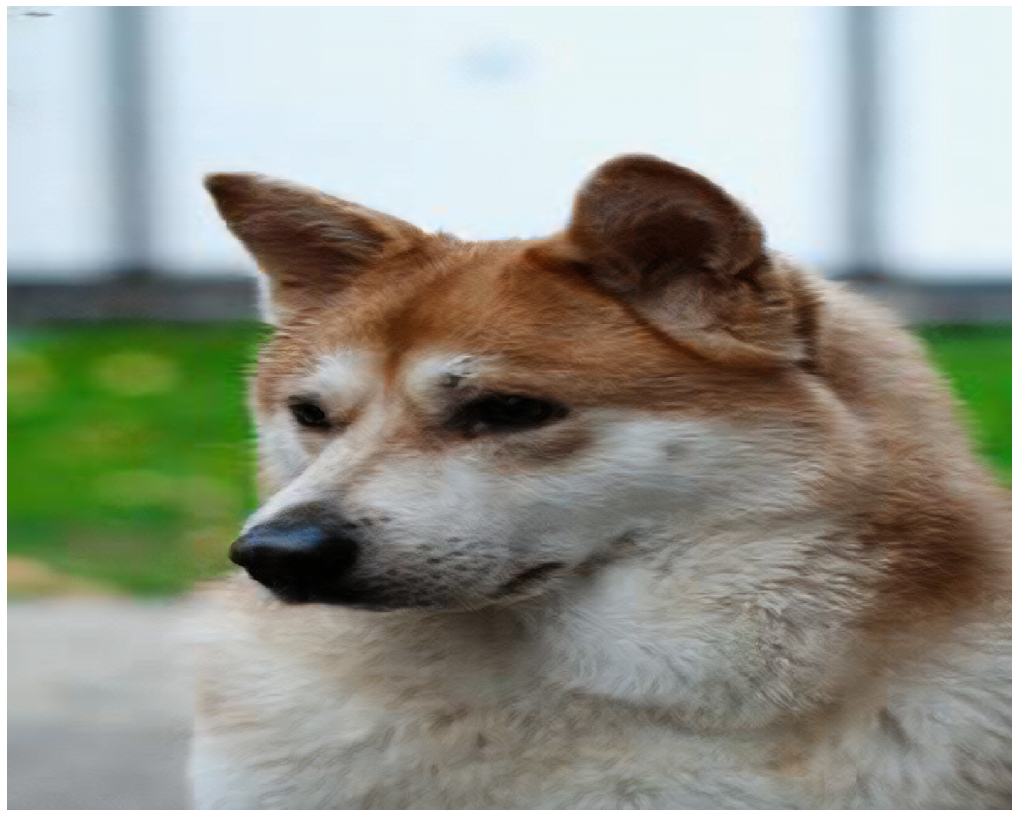

In [ ]:
# show_image(b, figsize=(18,15), interpolation='nearest');

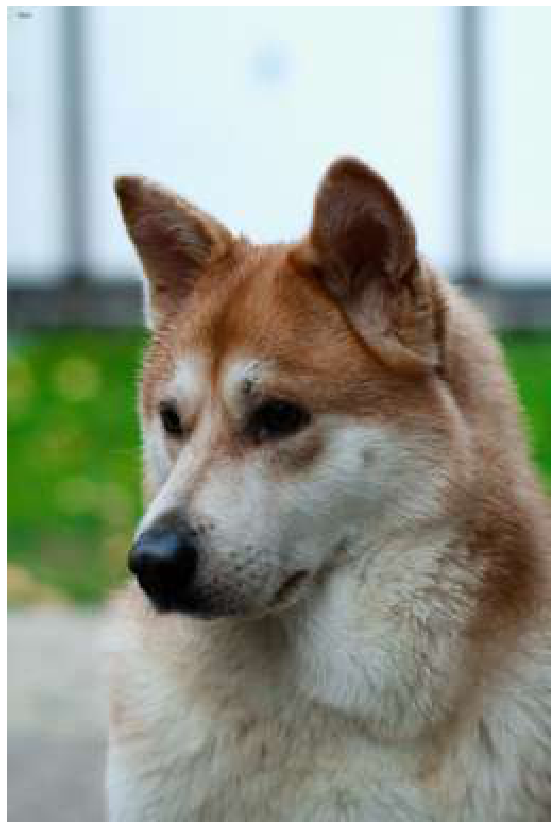

In [ ]:
show_image(img, figsize=(18,15), interpolation='nearest');

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


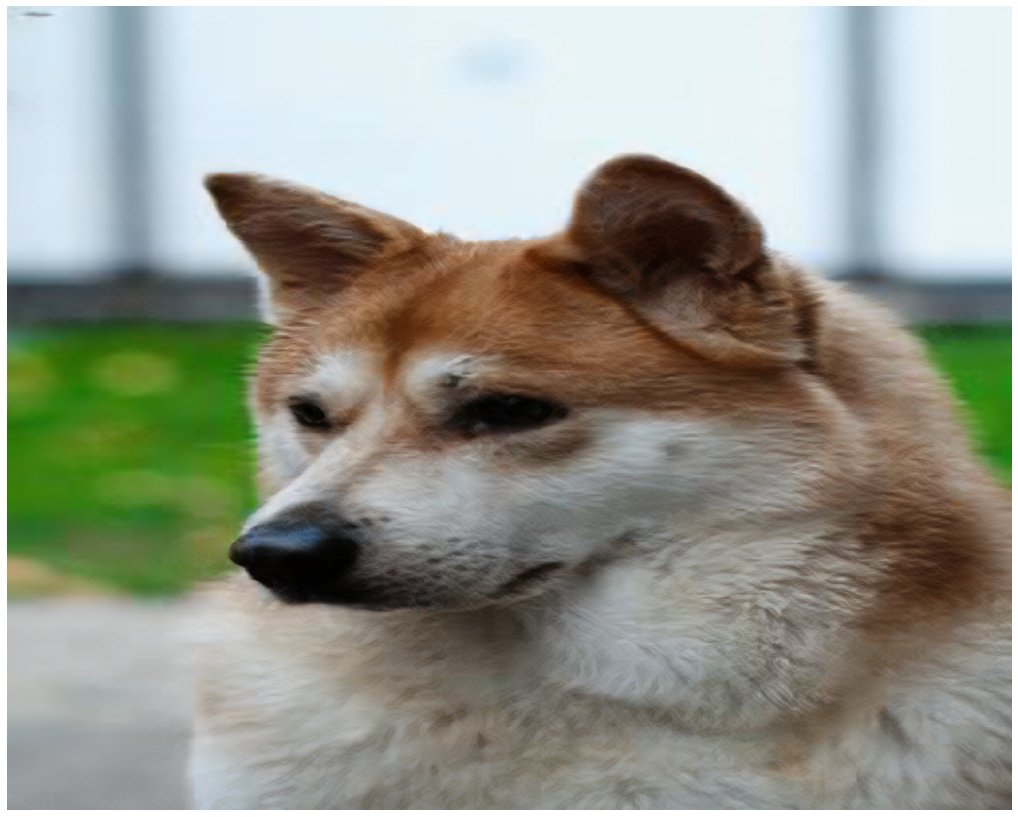

In [ ]:
Image(img_hr).show(figsize=(18,15))